### Stage 2 - PD modelling (logistic regression)

This notebook estimates a point-in-time PD proxy using origination features.

Workflow:
- load Stage 1 dataset (downsampled, with `sample_weight`)
- apply a maturity cutoff to reduce right-censoring from loan-status labeling
- engineer simple ratios
- time-based train/validation/test split
- fit candidate logistic models with a shared preprocessing pipeline
- choose the operating threshold using an FPR guardrail (weighted)
- calibrate predicted probabilities

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
    brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
os.makedirs("models", exist_ok=True)

In [ ]:
# Configuration
DATA_PATH = "data/loans_stage1_sampled.csv"
CUTOFF_MONTHS = 24  # remove the last N months of vintages to reduce censoring
TEST_SIZE = 0.20  # last 20% by time
VAL_SIZE = 0.15  # last 15% of train+val
TARGET_FPR = 0.20  # operating point guardrail (weighted)
N_BINS = 10     # quantile bins for monotonic-ish predictors
RANDOM_STATE = 14
TARGET = "default_12m"
WEIGHT = "sample_weight"

In [ ]:
loan = pd.read_csv(DATA_PATH)

#Enforce datetime + chronological order
loan["issue_d"] = pd.to_datetime(loan["issue_d"], errors="coerce")
loan = loan.dropna(subset=["issue_d"]).sort_values("issue_d").reset_index(drop=True)

#Required columns
missing_req = [c for c in [TARGET, WEIGHT] if c not in loan.columns]
if missing_req:
    raise ValueError(f"Missing required columns from Stage 1: {missing_req}")

#Maturity cutoff
max_issue = loan["issue_d"].max()
cutoff = max_issue - pd.DateOffset(months=CUTOFF_MONTHS)
loan = loan[loan["issue_d"] <= cutoff].copy().reset_index(drop=True)
print("Max issue_d:", max_issue.date(), "| Cutoff:", cutoff.date(), "| Rows kept:", len(loan))
print("Default rate after cutoff:", float(loan[TARGET].mean()))

#Simple feature engineering (guards included)
loan["revol_credit"] = loan["open_acc"] * (loan["revol_util"] / 100.0)
loan["loan_to_income"] = np.where(loan["annual_inc"] > 0, loan["loan_amnt"] / loan["annual_inc"], np.nan)

Max issue_d: 2018-12-01 | Cutoff: 2016-12-01 | Rows kept: 541736
Default rate after cutoff: 0.3986683550659362


In [4]:
drift = loan.groupby(loan["issue_d"].dt.year)[TARGET].agg(["mean", "count"])
display(drift)

,mean,count
issue_d,,
2011,0.376413,8759
2012,0.391521,22078
2013,0.380923,55187
2014,0.412486,99533
2015,0.420437,179040
2016,0.376422,177139


In [ ]:
def sub_grade_to_ord(x: str):
    # A1..G5 to 1..35
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper()
    if len(s) < 2:
        return np.nan
    letter = s[0]
    num = s[1:]
    if letter < "A" or letter > "G":
        return np.nan
    try:
        n = int(num)
    except:
        return np.nan
    if n < 1 or n > 5:
        return np.nan
    return (ord(letter) - ord("A")) * 5 + n

def emp_length_to_ord(x: str):
    # < 1 year, 1 year, ..., 10+ years, n/a
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["n/a", "na", "none", "nan", ""]:
        return np.nan
    if "<" in s:
        return 0
    if "10+" in s:
        return 10
    try:
        return int(s.split()[0])
    except:
        return np.nan

def term_to_num(x: str):
    # 36 months / 60 months -> 36 / 60
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    digits = "".join([c for c in s if c.isdigit()])
    try:
        return int(digits)
    except:
        return np.nan

#Feature set
v1_feature_set = [
    "loan_amnt", "term", "int_rate", "sub_grade", "purpose",
    "annual_inc", "emp_length", "home_ownership", "verification_status",
    "dti", "delinq_2yrs", "open_acc", "pub_rec", "revol_util",
    "revol_credit", "loan_to_income"]
loan_model = loan[v1_feature_set + [TARGET, WEIGHT, "issue_d"]].copy()

#Normalize string categories
for c in ["term", "emp_length", "sub_grade", "purpose", "home_ownership", "verification_status"]:
    loan_model[c] = loan_model[c].astype(str).str.strip()

#Ordinal numeric versions
loan_model["term_num"] = loan_model["term"].map(term_to_num)
loan_model["sub_grade_ord"] = loan_model["sub_grade"].map(sub_grade_to_ord)
loan_model["emp_length_ord"] = loan_model["emp_length"].map(emp_length_to_ord)

#Nominal vs ordinal
nominal_cat_cols = ["purpose", "home_ownership", "verification_status"]
ordinal_num_cols = ["term_num", "sub_grade_ord", "emp_length_ord"]

In [6]:
loan_model = loan_model.sort_values("issue_d").reset_index(drop=True)

n = len(loan_model)
test_start = int((1 - TEST_SIZE) * n)

trainval = loan_model.iloc[:test_start].copy()
test = loan_model.iloc[test_start:].copy()

val_start = int((1 - VAL_SIZE) * len(trainval))
train = trainval.iloc[:val_start].copy()
val = trainval.iloc[val_start:].copy()

X_train = train.drop(columns=[TARGET, WEIGHT, "issue_d"])
y_train = train[TARGET]
w_train = train[WEIGHT]

X_val = val.drop(columns=[TARGET, WEIGHT, "issue_d"])
y_val = val[TARGET]
w_val = val[WEIGHT]

X_test = test.drop(columns=[TARGET, WEIGHT, "issue_d"])
y_test = test[TARGET]
w_test = test[WEIGHT]

print("Rows:", {"train": len(train), "val": len(val), "test": len(test)})
print("Default rate:", {
    "train": float(y_train.mean()),
    "val": float(y_val.mean()),
    "test": float(y_test.mean())
})
print("Prevalence (val/test):", float(y_val.mean()), "/", float(y_test.mean()))

Rows: {'train': 368379, 'val': 65009, 'test': 108348}
Default rate: {'train': 0.4107644572573355, 'val': 0.38094725345721364, 'test': 0.3681747701849596}
Prevalence (val/test): 0.38094725345721364 / 0.3681747701849596


In [ ]:
#Binned predictors (monotonic-ish in credit)
binned_cols = ["int_rate", "dti", "revol_util", "loan_to_income"]

#Scaled numeric predictors
scaled_num_cols = ["loan_amnt", "annual_inc", "delinq_2yrs", "open_acc", "pub_rec", "revol_credit"]
scaled_all_num_cols = scaled_num_cols + ordinal_num_cols

binner = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("kbins", KBinsDiscretizer(
        n_bins=N_BINS,
        encode="onehot",
        strategy="quantile",
        quantile_method="averaged_inverted_cdf"
    ))
])

scaled_num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("bin", binner, binned_cols),
        ("num", scaled_num_pipe, scaled_all_num_cols),
        ("cat", cat_pipe, nominal_cat_cols),
    ],
    remainder="drop"
)

def build_model(**clf_params):
    clf = LogisticRegression(max_iter=5000, **clf_params)
    return Pipeline(steps=[("preprocess", preprocess), ("clf", clf)])

In [ ]:
def threshold_by_fpr(y_true, probs, w=None, target_fpr=0.20):
    fpr, tpr, thr = roc_curve(y_true, probs, sample_weight=w)
    idx = np.where(fpr <= target_fpr)[0]
    best_idx = idx[-1] if len(idx) else -1
    return float(thr[best_idx]), float(fpr[best_idx]), float(tpr[best_idx])

def evaluate(name, y_true, probs, threshold, w=None):
    auc = roc_auc_score(y_true, probs, sample_weight=w)
    ap = average_precision_score(y_true, probs, sample_weight=w)
    pred = (probs >= threshold).astype(int)
    print(f"\n[{name}] weighted ROC-AUC: {auc:.4f} | weighted PR-AUC: {ap:.4f} | threshold: {threshold:.3f}")
    print(confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred))
    return float(auc), float(ap)

def plot_roc(y_true, probs, w=None, title="ROC"):
    fpr, tpr, _ = roc_curve(y_true, probs, sample_weight=w)
    auc = roc_auc_score(y_true, probs, sample_weight=w)
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

def calibration_report(y_true, probs, w=None, title="Calibration"):
    brier = brier_score_loss(y_true, probs, sample_weight=w)
    frac_pos, mean_pred = calibration_curve(
        y_true, probs, n_bins=10, strategy="quantile"
    )
    print(f"\n[{title}] Brier score (weighted): {brier:.5f}")
    plt.plot(mean_pred, frac_pos, marker="o", label="Observed")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
    plt.xlabel("Mean predicted PD")
    plt.ylabel("Observed default rate")
    plt.title(title)
    plt.legend()
    plt.show()
    return float(brier)

In [ ]:
candidates = [
    ("BASELINE_L2", build_model()),
    ("BALANCED_L2", build_model(class_weight="balanced")),
    ("ELASTICNET", build_model(
        solver="saga",
        penalty="elasticnet",
        l1_ratio=0.5,
        C=1.0,
        class_weight="balanced"
    )),
]

results = []
for name, mdl in candidates:
    mdl.fit(X_train, y_train, clf__sample_weight=w_train)
    val_probs = mdl.predict_proba(X_val)[:, 1]
    thr, fpr_at, tpr_at = threshold_by_fpr(y_val, val_probs, w=w_val, target_fpr=TARGET_FPR)
    print(f"\n{name}: threshold for weighted FPR<={TARGET_FPR:.2f} is {thr:.3f} (FPR={fpr_at:.3f}, TPR={tpr_at:.3f})")
    val_auc, val_ap = evaluate(f"{name} - VAL", y_val, val_probs, thr, w=w_val)
    results.append((name, mdl, thr, val_auc, val_ap))
best_name, best_model, best_thr, best_val_auc, best_val_ap = sorted(results, key=lambda x: x[4], reverse=True)[0]

#Subsample for speed
X_val_small = X_val.sample(n=min(50000, len(X_val)), random_state=42)
y_val_small = y_val.loc[X_val_small.index]
r = permutation_importance(
    best_model,
    X_val_small,
    y_val_small,
    n_repeats=5,
    random_state=42,
    scoring="roc_auc"
)

#permutation_importance corresponds to RAW input columns
imp = pd.DataFrame({
    "feature": X_val_small.columns,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)
display(imp.head(20))
imp.to_csv("pd_top_drivers_perm_importance_raw.csv", index=False)
print("Saved: pd_top_drivers_perm_importance_raw.csv")


BASELINE_L2: threshold for weighted FPR<=0.20 is 0.222 (FPR=0.200, TPR=0.454)

[BASELINE_L2 - VAL] weighted ROC-AUC: 0.7015 | weighted PR-AUC: 0.2937 | threshold: 0.222
[[32197  8047]
 [13512 11253]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     40244
           1       0.58      0.45      0.51     24765

    accuracy                           0.67     65009
   macro avg       0.64      0.63      0.63     65009
weighted avg       0.66      0.67      0.66     65009


BALANCED_L2: threshold for weighted FPR<=0.20 is 0.577 (FPR=0.200, TPR=0.453)

[BALANCED_L2 - VAL] weighted ROC-AUC: 0.7014 | weighted PR-AUC: 0.2932 | threshold: 0.577
[[32196  8048]
 [13545 11220]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     40244
           1       0.58      0.45      0.51     24765

    accuracy                           0.67     65009
   macro avg       0.64      0.63      0.63     65009

,feature,importance
17,sub_grade_ord,0.118555
15,loan_to_income,0.008281
2,int_rate,0.006956
0,loan_amnt,0.006834
7,home_ownership,0.006575
9,dti,0.002160
11,open_acc,0.002068
8,verification_status,0.001974
12,pub_rec,0.000486
4,purpose,0.000356


Saved: pd_top_drivers_perm_importance_raw.csv


In [ ]:
test_probs = best_model.predict_proba(X_test)[:, 1]
test_auc, test_ap = evaluate(f"{best_name} - TEST", y_test, test_probs, best_thr, w=w_test)
print("\nWeighted test metrics:", {"ROC_AUC": test_auc, "PR_AUC": test_ap})


[BASELINE_L2 - TEST] weighted ROC-AUC: 0.6790 | weighted PR-AUC: 0.2666 | threshold: 0.222
[[55431 13026]
 [23785 16106]]
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     68457
           1       0.55      0.40      0.47     39891

    accuracy                           0.66    108348
   macro avg       0.63      0.61      0.61    108348
weighted avg       0.65      0.66      0.65    108348


Weighted test metrics: {'ROC_AUC': 0.6789944569827849, 'PR_AUC': 0.26658289287650694}


c:\Users\imagi\Documents\Queen Mary\Project Dissertation\try\venv\Lib\site-packages\sklearn\calibration.py:383: UserWarning: Since Pipeline does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(



CALIBRATED: threshold for weighted FPR<=0.20 is 0.221 (FPR=0.200, TPR=0.453)

[CALIBRATED - VAL] weighted ROC-AUC: 0.7016 | weighted PR-AUC: 0.2935 | threshold: 0.221
[[32197  8047]
 [13552 11213]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     40244
           1       0.58      0.45      0.51     24765

    accuracy                           0.67     65009
   macro avg       0.64      0.63      0.63     65009
weighted avg       0.66      0.67      0.66     65009


[CALIBRATED - TEST] weighted ROC-AUC: 0.6790 | weighted PR-AUC: 0.2663 | threshold: 0.221
[[55661 12796]
 [23949 15942]]
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     68457
           1       0.55      0.40      0.46     39891

    accuracy                           0.66    108348
   macro avg       0.63      0.61      0.61    108348
weighted avg       0.65      0.66      0.65    108348


[Uncalibrated (BASELINE_

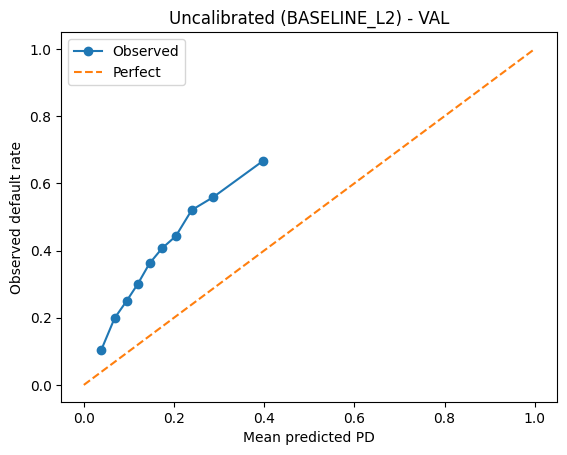


[Calibrated - VAL] Brier score (weighted): 0.12245


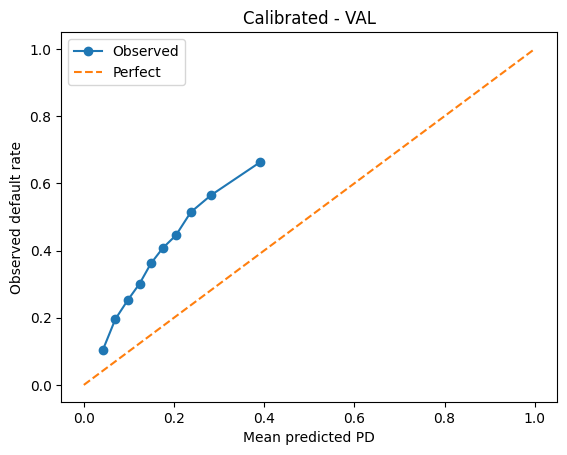

0.1224474809567796

In [11]:
cal = CalibratedClassifierCV(best_model, method="sigmoid", cv=3)
cal.fit(X_train, y_train, sample_weight=w_train)

val_probs_cal = cal.predict_proba(X_val)[:, 1]
thr_cal, fpr_at, tpr_at = threshold_by_fpr(y_val, val_probs_cal, w=w_val, target_fpr=TARGET_FPR)

print(f"\nCALIBRATED: threshold for weighted FPR<={TARGET_FPR:.2f} is {thr_cal:.3f} (FPR={fpr_at:.3f}, TPR={tpr_at:.3f})")
cal_val_auc, cal_val_ap = evaluate("CALIBRATED - VAL", y_val, val_probs_cal, thr_cal, w=w_val)

test_probs_cal = cal.predict_proba(X_test)[:, 1]
cal_test_auc, cal_test_ap = evaluate("CALIBRATED - TEST", y_test, test_probs_cal, thr_cal, w=w_test)

calibration_report(y_val, best_model.predict_proba(X_val)[:, 1], w=w_val, title=f"Uncalibrated ({best_name}) - VAL")
calibration_report(y_val, val_probs_cal, w=w_val, title="Calibrated - VAL")

In [12]:
import joblib

MODEL_PATH = "models/pd_model_stage2.joblib"
CAL_MODEL_PATH = "models/pd_model_stage2_calibrated.joblib"
META_PATH = "models/pd_model_stage2_meta.json"

joblib.dump(best_model, MODEL_PATH)
joblib.dump(cal, CAL_MODEL_PATH)

meta = {
    "data_path": DATA_PATH,
    "cutoff_months": CUTOFF_MONTHS,
    "test_size": TEST_SIZE,
    "val_size": VAL_SIZE,
    "target_fpr": TARGET_FPR,
    "n_bins": N_BINS,
    "best_model": best_name,
    "best_threshold_uncalibrated": best_thr,
    "threshold_calibrated": float(thr_cal),
    "val_metrics_uncalibrated": {"roc_auc": best_val_auc, "pr_auc": best_val_ap},
    "test_metrics_uncalibrated": {"roc_auc": test_auc, "pr_auc": test_ap},
    "val_metrics_calibrated": {"roc_auc": float(cal_val_auc), "pr_auc": float(cal_val_ap)},
    "test_metrics_calibrated": {"roc_auc": float(cal_test_auc), "pr_auc": float(cal_test_ap)},
}

with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:", MODEL_PATH)
print("Saved:", CAL_MODEL_PATH)
print("Saved:", META_PATH)

Saved: models/pd_model_stage2.joblib
Saved: models/pd_model_stage2_calibrated.joblib
Saved: models/pd_model_stage2_meta.json
